# Feature Importance

In [1]:
using Flux
using BSON: @load
using Chemfiles
using Plots

struct G2
    eta::Float64
    rcutoff::Float64
    rshift::Float64
end

function build_distance_matrix(frame)
    N = length(frame)
    return [distance(frame, i - 1, j - 1) for i in 1:N, j in 1:N]
end

function distance_cutoff(d, rcutoff=10.0)
    return d > rcutoff ? 0.0 : 0.5 * (cos(π * d / rcutoff) + 1.0)
end

function compute_g2(distances, eta, rcutoff, rshift)
    return sum(exp(-eta * (d - rshift)^2) * distance_cutoff(d, rcutoff) for d in distances if d > 0.0)
end

function build_g2_matrix(distance_matrix, g2_functions)
    N = size(distance_matrix, 1)
    g2_matrix = zeros(Float64, N, length(g2_functions))
    for i in 1:N
        distances = distance_matrix[i, :]
        for (j, g2_func) in enumerate(g2_functions)
            g2_matrix[i, j] = compute_g2(distances, g2_func.eta, g2_func.rcutoff, g2_func.rshift)
        end
    end
    return g2_matrix
end

build_g2_matrix (generic function with 1 method)

In [2]:
MODEL_PATH = "methanol-CG-NN.bson"

g2_list = [G2(0.125, 7.0, 0.00),
    G2(4.000, 7.0, 3.00),
    G2(4.000, 7.0, 3.50),
    G2(4.000, 7.0, 4.00),
    G2(4.000, 7.0, 4.50),
    G2(4.000, 7.0, 5.00),
    G2(4.000, 7.0, 5.50),
    G2(4.000, 7.0, 6.00),]

8-element Vector{G2}:
 G2(0.125, 7.0, 0.0)
 G2(4.0, 7.0, 3.0)
 G2(4.0, 7.0, 3.5)
 G2(4.0, 7.0, 4.0)
 G2(4.0, 7.0, 4.5)
 G2(4.0, 7.0, 5.0)
 G2(4.0, 7.0, 5.5)
 G2(4.0, 7.0, 6.0)

In [3]:
@load MODEL_PATH model

In [4]:
traj = Trajectory("100CH3OH-CG.pdb")
frame = read(traj)
distance_mat = build_distance_matrix(frame)
g2_mat = build_g2_matrix(distance_mat, g2_list)

512×8 Matrix{Float64}:
 0.348011  0.701036   0.827615  0.375171  …  0.952974  0.557188  0.305953
 0.290638  0.0954002  0.827272  1.34109      1.04923   0.772424  0.389576
 0.466721  0.885657   1.08009   0.948012     0.888081  0.672205  0.307596
 0.443947  0.746694   1.17936   1.11746      0.695501  0.579542  0.278361
 0.443389  0.797283   1.1569    0.698395     1.17827   0.551984  0.255756
 0.428908  0.293085   1.46702   1.70244   …  0.77508   0.431131  0.126479
 0.367822  0.494233   1.01415   0.983206     0.852152  0.443751  0.304497
 0.413995  0.806509   0.944548  0.76023      0.663992  0.562111  0.345514
 0.331651  0.345392   0.843541  1.20608      0.625207  0.520301  0.389188
 0.436414  0.862709   0.882515  0.581193     1.35943   0.490459  0.276129
 ⋮                                        ⋱  ⋮                   
 0.468686  0.903962   1.11405   1.09556      0.644413  0.275079  0.184728
 0.398206  0.346204   1.69296   1.19813      0.699262  0.660219  0.371833
 0.288478  0.267284   1

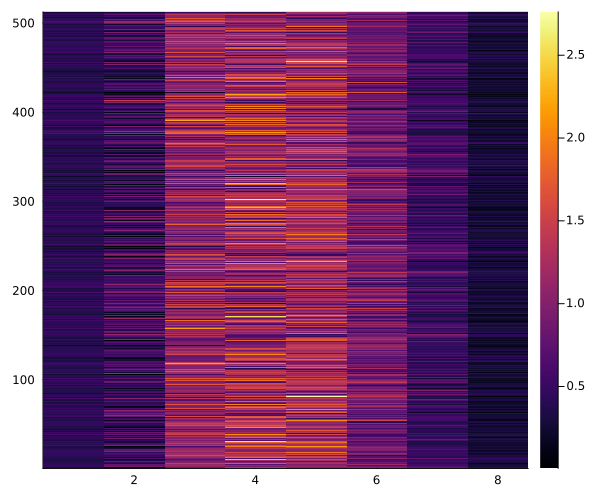

In [5]:
heatmap(g2_mat, size=(600, 500))

In [6]:
acc_vec = zeros(length(g2_list))
for row in 1:length(g2_mat[:, 1])
    acc_vec .+= g2_mat[row, :]
end

reference_input = acc_vec / length(g2_mat[:, 1])

8-element Vector{Float64}:
 0.4099175292674764
 0.5403441713164673
 1.110150970806575
 1.188133416193503
 1.1897142157432985
 0.8872147743505632
 0.5402692803752793
 0.2805322867071562

# Set Neuron to Zero

In [7]:
e_reference = model(reference_input)
errors_zeros = zeros(length(reference_input))

for n_g2 in 1:length(reference_input)
    error = 0.0
    tmp_input = copy(reference_input)
    tmp_input[n_g2] = 0
    e_tmp = model(tmp_input)
    error = abs(e_reference[1] - e_tmp[1]) / abs(e_reference[1]) * 100
    errors_zeros[n_g2] = error
    println("Number: $n_g2, Error: $(error) %")
end

Number: 1, Error: 1374.4423039966882 %
Number: 2, Error: 530.4000658876306 %
Number: 3, Error: 494.7036188443821 %
Number: 4, Error: 396.45115552150855 %
Number: 5, Error: 304.9715722199378 %
Number: 6, Error: 123.27597719663387 %
Number: 7, Error: 39.10511946232251 %
Number: 8, Error: 10.47223146120807 %


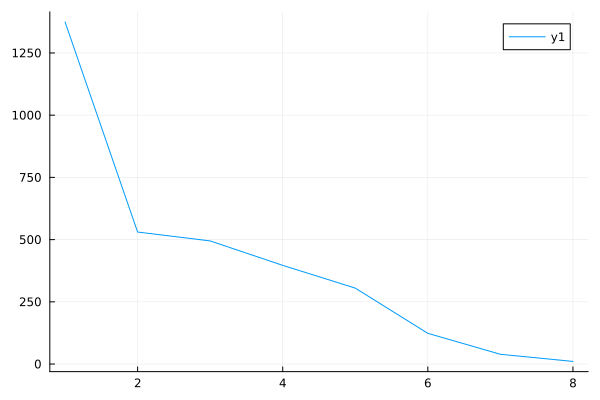

In [8]:
plot(errors_zeros)

# Small changes with grid from -1 to +1

In [9]:
e_reference = model(reference_input)
errors_shift = zeros(length(reference_input))

# Задаем шаг сетки
step_size = 0.001
grid_range = -0.1:step_size:0.1

for n_g2 in 1:length(reference_input)
    total_error = 0.0  # Для накопленной ошибки
    count = 0  # Для подсчёта среднего

    for delta in grid_range
        tmp_input = copy(reference_input)
        tmp_input[n_g2] += delta  # Изменяем текущий элемент по сетке

        e_tmp = model(tmp_input)
        error = abs(e_reference[1] - e_tmp[1]) / abs(e_reference[1]) * 100

        total_error += error
        count += 1

        # println("Element: $n_g2, Delta: $delta, Error: $(error) %")
    end

    # Считаем среднюю ошибку
    average_error = total_error / count
    errors_shift[n_g2] = average_error

    println("Element: $n_g2, Total Error: $(total_error) %, Average Error: $(average_error) %")
end


Element: 1, Total Error: 44335.10177637949 %, Average Error: 220.57264565362928 %
Element: 2, Total Error: 9914.126865500273 %, Average Error: 49.324014256220266 %
Element: 3, Total Error: 4500.74510739568 %, Average Error: 22.391766703461094 %
Element: 4, Total Error: 3370.1237724594985 %, Average Error: 16.766784937609444 %
Element: 5, Total Error: 2589.035953896669 %, Average Error: 12.88077589003318 %
Element: 6, Total Error: 1403.366361428545 %, Average Error: 6.981922196161915 %
Element: 7, Total Error: 731.046018931725 %, Average Error: 3.63704487030709 %
Element: 8, Total Error: 377.0316030276123 %, Average Error: 1.8757791195403597 %


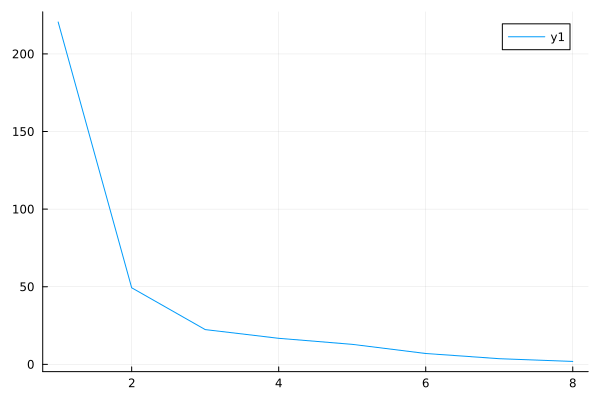

In [10]:
plot(errors_shift)

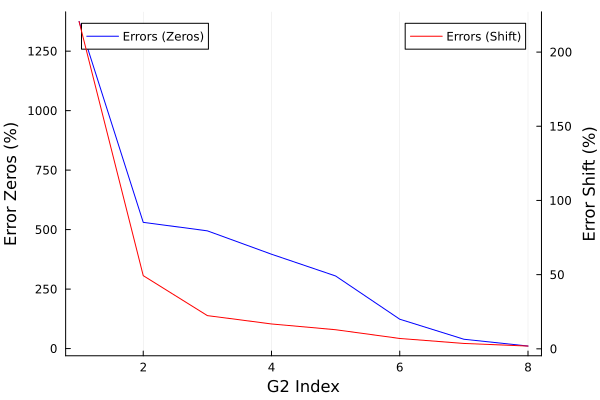

In [11]:
# Строим первый график
p1 = plot(errors_zeros, label="Errors (Zeros)", color=:blue, xlabel="G2 Index", ylabel="Error Zeros (%)", legend=:topleft)

# Добавляем второй график на вторую ось (справа)
plot!(twinx(), errors_shift, label="Errors (Shift)", color=:red, ylabel="Error Shift (%)", legend=:topright)

# Показываем график
display(p1)

In [12]:
errors_zeros

8-element Vector{Float64}:
 1374.4423039966882
  530.4000658876306
  494.7036188443821
  396.45115552150855
  304.9715722199378
  123.27597719663387
   39.10511946232251
   10.47223146120807

In [13]:
errors_shift

8-element Vector{Float64}:
 220.57264565362928
  49.324014256220266
  22.391766703461094
  16.766784937609444
  12.88077589003318
   6.981922196161915
   3.63704487030709
   1.8757791195403597